# Previsão do preço de vendas de tratores de esteira utilizando Machine Learning

Este notebook tem o propósito de elaborar um modelo de regressão para prever o preço de um trator de esteira. Para abordar o problema, será utilizado o workflow descrito a seguir.

    1. Definição do problema

    Quão precisamente conseguimos prever o preço de venda de tratatores de esteira no futuro, dadas as suas características e preços de tratos vendidos no passado? Para realizar um estimativa de valores numéricos baseadas em características, deveremos utilizar um modelo de Reressão.

    2. Dados

    A base de dados foi obtida no Kaggle: https://www.kaggle.com/c/bluebook-for-bulldozers/. 
    
    - TrainandValid.csv é a base de dados que combina a base de testes e de treino, e que será utiliza no modelo de regressão.
    - Test.csv é a base de dados para a qual serão feitas as previsões.

    3. Avaliação

    A métrica de avaliação do modelo será a raiz do erro logarítmico quadrático médio entre o preço calculado através do modelo e o preço real.

    4. Atributos

    O Kaggle disponibiliza um detalhamento dos atributos dos dados utilizados no dataset. Você pode acessar estes dados em: https://github.com/ms-r0bot/Data-Science-Machine-Learning/blob/main/bulldozers-price-prediction-project/Data%20Dictionary.xlsx.

# 1. Tratamento dos dados

In [1]:
# Primeiramente, é necessário importar os módulos utilizados para o tratamento dos dados

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importar o dados de treino e validação (neste momento, ainda é uma base histórica única) 

df = pd.read_csv('TrainAndValid.csv',low_memory=False)

# Vamos visualizar informações gerais sobre o dataset:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [3]:
# Para iniciar o tratamento dos dados, primeiramente é necessário 'parsear' as datas, dizendo ao Pandas em quais colunas nos possuímos este tipo de dado. Para isso, será utilizado o argumento parse_dates=['saledate']:

df = pd.read_csv('TrainAndValid.csv',low_memory=False, parse_dates=['saledate'])


In [4]:
# Para enriquecer a nossa análise, vamos adicionar algumas colunas que extraem informações da coluna 'saledate': ano de venda, mês, dia da semana, dia do ano e dia do mês. Em seguida, vamos remover a coluna 'saledate' e visualizar novamente os dados.

df['saleYear'] = df.saledate.dt.year
df['saleMonth'] = df.saledate.dt.month
df['saleDayOfWeek'] = df.saledate.dt.dayofweek
df['saleDay'] = df.saledate.dt.day
df['saleDayOfYear'] = df.saledate.dt.dayofyear

df.drop('saledate', axis=1, inplace=True)
df.head().T


,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [5]:
# Finalmente, serão tratados os campos que possuem dados em branco. Valores numéricos em branco podem ser encontrados nas seguintes colunas:

for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)


auctioneerID
MachineHoursCurrentMeter


In [6]:
# Como MachineHoursCurrentMeter não podem ser inferido de nenhuma forma, valores nulos serão substituídos pela mediana. 

# Substituir valores nulos(NaN) pela mediana.

for label, content in df.items():
    if label == 'MachineHoursCurrentMeter':
        if pd.isnull(content).sum():
          df[label] = content.fillna(content.median())

In [7]:
# Já o campo auctioneerID (que também não pode ser inferido) será substituído aleatoriamente por um dos valores da série (com excessão de nulo):

df_aux = df['auctioneerID'].unique()
df_aux = df_aux[np.logical_not(np.isnan(df_aux))]

# Substituir valores nulos pelo random do auctioneerID:

for label, content in df.items():
    if label == 'auctioneerID':
         if pd.isnull(content).sum():
            df[label] = content.fillna(value=np.random.choice(df_aux))

In [8]:
# O próximo passo para o tratamento é transformar os dados do tipo string em tipo categoria.

for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [9]:
# Em campos categóricos vazios, o código que traz a informação de campo vazio é -1. Por isso, ao somar +1, os campos vazios passam a ter código = 0 e os campos que já possuiam algum valor ficam com código = [código + 1].

for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull:
            df[label] = pd.Categorical(content).codes+1  
                

# 2. Construção do modelo de Machine Learning

In [10]:
# Importar o módulo que possui o modelo de regressão que utilizaremos:

from sklearn.ensemble import RandomForestRegressor

In [11]:
# Instanciar o modelo, indicando que toda a capacidade de processamento do computador pode ser utilizada e tornando-o reproduzível.
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=None)

In [12]:
%%time

#Separar os dados para treino e validação

df_val = df[df.saleYear == 2012]
df_train = df[df.saleYear != 2012]

# 'Treinar' o modelo nos dados

X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']
model.fit(X_train, y_train)

CPU times: user 15min 12s, sys: 7.45 s, total: 15min 19s
Wall time: 6min


RandomForestRegressor(n_jobs=-1, random_state=42)

# 3. Construção da função de avaliação do modelo


In [13]:
# Conforme citado anteriormente, a métrica de avaliação do modelo será a raiz do erro logarítmico quadrático médio entre o preço calculado através do modelo e o preço real. Para isso, será construída uma função.

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Esta função calcula a raiz do erro logarítmico quadrático médio (RMSLE) entre os valores calculados e os valores reais.
    '''

    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#Vamos criar também uma função para avaliar o modelo em níveis diferentes

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              '-> Valid RMSLE': rmsle(y_valid,val_preds),
              'Training R²': r2_score(y_train, train_preds),
              'Valid R²': r2_score(y_valid, val_preds)}
    return scores


In [14]:
show_scores(model)

{'Training MAE': 1577.7902596198192,
 'Valid MAE': 6111.417041389441,
 'Training RMSLE': 0.08413119074594147,
 '-> Valid RMSLE': 0.2537439802580447,
 'Training R²': 0.9875312509494447,
 'Valid R²': 0.8730471013740366}

In [15]:
%%time

#  Apesar dos resultados obtidos terem sido bastante satisfatórios, vamos tentar melhor ainda mais o modelo ao ajustar os hiperparâmetros. Para isso, utilizaremos o RandomizedSearchCV, que ajusta os hiperparâmetros de forma aleatória dentro da biblioteca que determinamos.

from sklearn.model_selection import RandomizedSearchCV

rf_grid = {'n_estimators': np.arange(10,100,10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2),
           'max_features': ['auto','sqrt',0.5,1],
           'max_samples': [None]}


rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                                                    param_distributions = rf_grid,
                                                    n_iter=100,
                                                    cv=5,
                                                    verbose=True)

rs_model.fit(X_train,y_train)

# Com os valores definidos acima, o modelo demora cerca de 4h para ser treinado!  

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 192.3min finished
CPU times: user 9min 25s, sys: 41.8 s, total: 10min 6s
Wall time: 3h 13min 20s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': ['auto', 'sqrt', 0.5,
                                                         1],
                                        'max_samples': [None],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [16]:
# Os hiperparâmetros utilizados para encontrar a solução ótima:

rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_samples': None,
 'max_features': 0.5,
 'max_depth': None}

In [17]:
# A 'pontuação' do modelo otimizado:

show_scores(rs_model)

{'Training MAE': 3494.763360844729,
 'Valid MAE': 5937.381835921802,
 'Training RMSLE': 0.17006053723295278,
 '-> Valid RMSLE': 0.2437265526762202,
 'Training R²': 0.940976400431087,
 'Valid R²': 0.8802173634170052}

In [18]:
# Com o RandomizedSearchCV, foi possível chegar a um resultado com hiperparâmetros melhores: o RMSLE para os dados de validação reduziu de 0.253 para 0.244.

In [21]:
# Vamos treinar novamente o modelo com os melhor hiperparâmetros

ideal_model = RandomForestRegressor(n_estimators= 70,
                                    min_samples_split = 10,
                                    min_samples_leaf = 7,
                                    max_samples = None,
                                    max_features = 0.5,
                                    max_depth = None,
                                    random_state = 42)

ideal_model.fit(X_train,y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=7,
                      min_samples_split=10, n_estimators=70, random_state=42)

In [43]:

show_scores(ideal_model)

{'Training MAE': 3494.763360844729,
 'Valid MAE': 5937.381835921802,
 'Training RMSLE': 0.17006053723295278,
 '-> Valid RMSLE': 0.2437265526762202,
 'Training R²': 0.940976400431087,
 'Valid R²': 0.8802173634170052}

# 4. Realizando projeções sobre os dados de teste

In [22]:
# Agora que construímos e melhoramos o modelo, vamos realizar predições sobre dados de um período posterior ao período utilizado na modelagem.

df_test = pd.read_csv('Test.csv', low_memory=False, parse_dates=['saledate'])

df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688,28555,6038,8940,2286
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [23]:
# Com os dados de teste, precisamos fazer os mesmos procedimentos para tratar os dados: remover dados ausentes, organizar as colunas de datas... Para isso, será criada a função abaixo:

def preprocess_data(df):

    # Ajustar dados de data
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis=1, inplace=True)
    
    df_aux = df['auctioneerID'].unique()
    df_aux = df_aux[np.logical_not(np.isnan(df_aux))]
    
    for label, content in df.items():
        #Substituir o Nan e nulo do MachineHoursCurrentMeter pela mediana:
        if label == 'MachineHoursCurrentMeter':
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())

        #Substituir o Nan e nulo do auctioneerID pelo random:
        if label == 'auctioneerID':
            if pd.isnull(content).sum():
               df[label] = content.fillna(value=np.random.choice(df_aux))

        #Transformar categorias em números:
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1

    return df
    

In [24]:
# Preparar os dados teste com a função de preprocessamento:

df_test = preprocess_data(df_test)

In [25]:
# Com os dados de df_test no mesmo formato dos dados utilizados para treinar o modelo, poderemos agora utilizar nosso modelo para fazer previsões sobre os dados de teste:

test_preds = ideal_model.predict(df_test)

In [26]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

# O DataFrame abaixo apresenta valores de venda previstos, gerados pelo modelo de MachineLearning.

,SalesID,SalesPrice
0,1227829,17821.117576
1,1227844,16570.776212
2,1227847,51103.067692
3,1227848,65570.615813
4,1227863,56663.802690
...,...,...
12452,6643171,38511.988109
12453,6643173,12352.357264
12454,6643184,13370.069389
12455,6643186,15567.448982


# EXTRA: Relevância dos atributos no modelo construído

In [27]:
# Alguns atributos dos tratores de esteira tem mais 'peso' no valor de venda do que outros. A seguir, vamos descobrir quais são os atributos que mais pesam no modelo, e em que medida.

ideal_model.feature_importances_

array([3.21892892e-02, 1.59209922e-02, 4.52077693e-02, 2.08937292e-03,
       2.59421088e-03, 2.00135217e-01, 2.69358073e-03, 8.89054959e-04,
       4.07092119e-02, 4.75192565e-02, 6.54433695e-02, 5.73268823e-03,
       3.03885552e-02, 1.62408010e-01, 4.36693904e-02, 4.62699588e-03,
       6.65319390e-03, 6.05777205e-03, 3.29586174e-03, 8.14868280e-02,
       7.45813952e-04, 2.98783262e-03, 1.18258941e-03, 3.84938692e-04,
       1.03468251e-03, 3.73552751e-05, 2.60137071e-03, 1.34124881e-02,
       2.00645963e-03, 1.61768790e-03, 6.20974933e-03, 3.68575417e-03,
       4.69888470e-03, 9.37830314e-04, 1.83462826e-03, 1.56442211e-02,
       1.35097603e-03, 2.13143482e-02, 3.29099634e-03, 9.59919725e-03,
       1.35060111e-03, 1.00589674e-03, 4.21336227e-03, 5.25486476e-04,
       6.02340573e-04, 2.80026852e-04, 5.29057883e-04, 3.45922792e-03,
       1.35893291e-03, 5.06954632e-04, 2.97975193e-04, 7.35851504e-02,
       3.39748482e-03, 2.10430284e-03, 4.28219540e-03, 8.21257904e-03])

In [49]:
# Um array não nos diz muito, por isso vamos plotar um gráfico com os 20 atributos mais importantes:

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features':columns,
                        'feature_importances':importances})
                        .sort_values('feature_importances',ascending=False)
                        .reset_index(drop=True))
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(df['features'][:n],df['feature_importances'][:20])
    ax.set_ylabel('Atributos')
    ax.set_xlabel('Relevância do atributo')
    ax.invert_yaxis()
    ax.set_title('Relevância dos atributos no preço de venda de tratores de esteira')


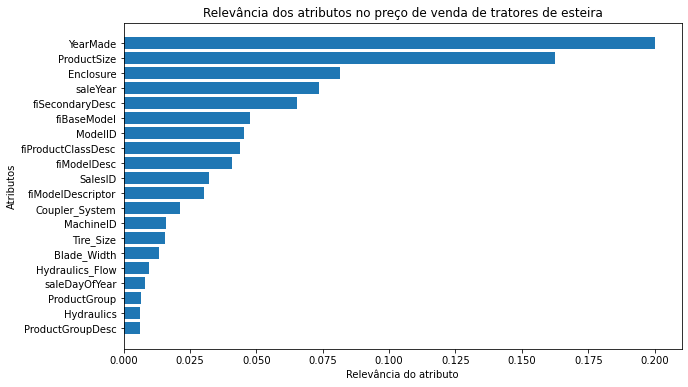

In [50]:
plot_features(X_train.columns, ideal_model.feature_importances_);